# Calculus I: Regression with PyTorch

In [24]:
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt

In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse

In [25]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11.]) # E.g.: Dosage of drug for treating Alzheimer's disease
x

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 

In [26]:
y = -0.5*x + 2 + torch.normal(mean=torch.zeros(12), std=0.3)
y

tensor([ 2.3257e+00,  1.4139e+00,  1.2547e+00,  7.8083e-01,  3.9970e-01,
        -2.5848e-03, -7.4135e-01, -1.1481e+00, -1.8980e+00, -2.5958e+00,
        -3.1293e+00, -2.8750e+00])

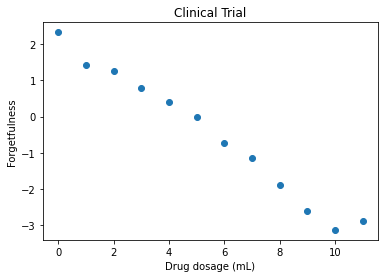

In [27]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9...

(**N.B.**: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

In [28]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

...and do the same for the $y$-intercept parameter $b$: 

In [29]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [30]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [31]:
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()
    
    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

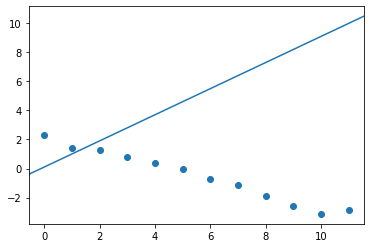

In [32]:
regression_plot(x, y, m, b)

### Machine Learning

#### **Step 1**: Forward Pass

In [33]:
yhat = regression(x, m, b)
yhat

tensor([ 0.1000,  1.0000,  1.9000,  2.8000,  3.7000,  4.6000,  5.5000,  6.4000,
         7.3000,  8.2000,  9.1000, 10.0000], grad_fn=<AddBackward0>)

#### **Step 2**: Compare $\hat{y}$ with true $y$ to calculate LOSS $C$

In [34]:
# define mean square error function
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [35]:
C = mse(yhat, y)
C

tensor(54.5080, grad_fn=<DivBackward0>)

#### **Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [36]:
# differentiate loss function w.r.t. parameters m & b
C.backward()

In [37]:
# the number conveys insights on how to adjust our parameter m to reduce C
m.grad

tensor([94.6829])

In [38]:
# same for the parameter b
b.grad

tensor([11.1359])

#### **Step 4**: Gradient descent

In [39]:
optimizer = torch.optim.SGD([m,b], lr=.01)

In [40]:
# recall the initial values of the parameters
print(m, b)

tensor([0.9000], requires_grad=True) tensor([0.1000], requires_grad=True)


In [41]:
optimizer.step()

Confirm parameters have been adjusted sensibly: 

In [42]:
print(m, b)

tensor([-0.0468], requires_grad=True) tensor([-0.0114], requires_grad=True)


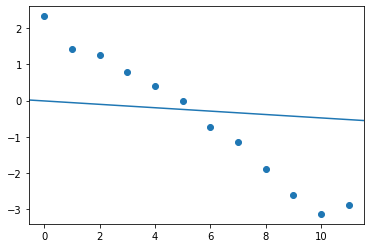

In [43]:
regression_plot(x, y, m, b)

Let's check if the loss has reduced:

In [44]:
C = mse(regression(x,m,b), y)
print(C)

tensor(2.5934, grad_fn=<DivBackward0>)


Put the 4 steps in a loop to iteratively minimize loss toward zero: 

In [45]:
epochs = 1000
for epoch in range(epochs):
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhat = regression(x, m, b) # Step 1
    C = mse(yhat, y) # Step 2
    
    C.backward() # Step 3
    optimizer.step() # Step 4
    
    print('Epoch {}, loss {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, loss 2.59, m grad 13.6, b grad 0.498
Epoch 1, loss 1.53, m grad 2.08, b grad -1.01
Epoch 2, loss 1.49, m grad 0.436, b grad -1.22
Epoch 3, loss 1.47, m grad 0.202, b grad -1.24
Epoch 4, loss 1.46, m grad 0.168, b grad -1.24
Epoch 5, loss 1.44, m grad 0.163, b grad -1.23
Epoch 6, loss 1.43, m grad 0.161, b grad -1.23
Epoch 7, loss 1.41, m grad 0.16, b grad -1.22
Epoch 8, loss 1.4, m grad 0.159, b grad -1.21
Epoch 9, loss 1.38, m grad 0.158, b grad -1.2
Epoch 10, loss 1.37, m grad 0.157, b grad -1.2
Epoch 11, loss 1.35, m grad 0.156, b grad -1.19
Epoch 12, loss 1.34, m grad 0.156, b grad -1.18
Epoch 13, loss 1.32, m grad 0.155, b grad -1.18
Epoch 14, loss 1.31, m grad 0.154, b grad -1.17
Epoch 15, loss 1.3, m grad 0.153, b grad -1.17
Epoch 16, loss 1.28, m grad 0.152, b grad -1.16
Epoch 17, loss 1.27, m grad 0.151, b grad -1.15
Epoch 18, loss 1.25, m grad 0.15, b grad -1.15
Epoch 19, loss 1.24, m grad 0.15, b grad -1.14
Epoch 20, loss 1.23, m grad 0.149, b grad -1.13
Epoch 21, l

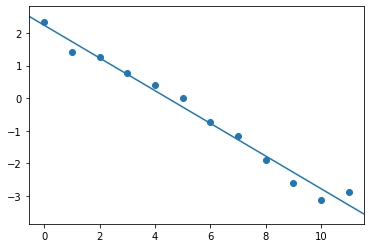

In [46]:
regression_plot(x, y, m, b)

In [48]:
print(m.item(), b.item())

-0.5017500519752502 2.2392730712890625


**N.B.**: The model doesn't perfectly approximate the slope (-0.5) and $y$-intercept (2.0) used to simulate the outcomes $y$ at the top of this notebook. This reflects the imperfectness of the sample of eight data points due to adding random noise during the simulation step. In the real world, the best solution would be to sample additional data points: The more data we sample, the more accurate our estimates of the true underlying parameters will be. 